# Support Vector Machine classifiers (1.5 points)

In this assignment, we use the scikit-learn package to train an SVM classifier. To do so, we need to tune 2 hyperparameters: the cost $C$ and precision $\gamma$ (gamma). We are going to use $K$-fold cross-validation to determine the best combination of values for this pair.

 - <a href='#question0'>Question 0</a> (.0) Have a look at the 3 first cells. In the <a href='#third-cell'>third one</a>, take note of how the `SVC` object is instantiated and trained, how labels are predicted, and finally how the fitting error is computed. In this assignment, the prediction error after a given training is simply defined as the *number of misclassified labels*.
 - <a href='#question1'>Question 1</a> (.9) Using an SVM classifier with an RBF kernel, use 10-fold cross-validation to find the best cost and precision parameters. The range of test values for each parameter is provided. 
  - <a href='#question1a'>a.</a> First compute the cross-validation error matrix: for each parameter combination, instantiate an SVM classifier; for each split provided by the `KFold` object, re-train this classifier and compute the prediction error; the cross-validation error is the average of these errors over all splits.
  - <a href='#question1b'>b.</a> Use the error matrix to select the best parameter combination. 
  - <a href='#question1c'>c.</a> Visualize the error matrix using `imshow` and the 'hot' colormap.
 - <a href='#question2'>Question 2</a> (.5) Plot the decision boundaries of this classifier, by appropriately modifying the code from the previous assignments. Display the support vectors on the same figure.
 - <a href='#question3'>Question 3</a> (.1) Evaluate and print the generalization error of this classifier, computed on the test set.

<a id='question0'></a>

# Code

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.svm import SVC
%matplotlib inline

## Load and display the training data

features size: (500, 2)
labels size: (500,)


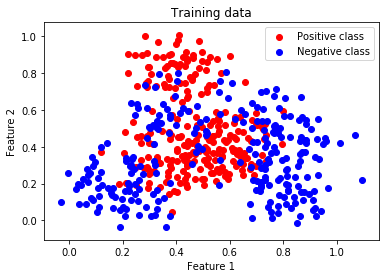

In [2]:
features = np.load("features.npy")
labels = np.load("labels.npy")
print("features size:", features.shape)
print("labels size:", labels.shape)

# Extract features for both classes
pos = labels == 1  # 1D array of booleans, with pos[i] = True if labels[i] == 1
features_pos = features[pos]  # filter the array with the boolean array
neg = labels != 1
features_neg = features[neg]

# Display data
fig, ax = plt.subplots()
ax.scatter(features_pos[:, 0], features_pos[:, 1], c="red", label="Positive class")
ax.scatter(features_neg[:, 0], features_neg[:, 1], c="blue", label="Negative class")
ax.set_title("Training data")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.legend()

plt.show()

<a id='third-cell'></a>

## Training the SVM classifier with arbitrary hyperparameters

In [3]:
cost = 1
gamma = 1

# Train the SVM classifier.
svm = SVC(C=cost, kernel='rbf', gamma=gamma)
svm.fit(features, labels)

# Predict labels.
# Note that here we use the same set for training and testing,
# which is not the case in the remainder of the assignment.
predicted_labels = svm.predict(features)

# Compute the error.
# Note: since in Python, True and False are equivalent to 1 and 0, we can
# directly sum over the boolean array returned by the comparison operator. 
error = sum(labels != predicted_labels)
print("Prediction error:", error)

Prediction error: 98


<a id='question1'></a>

## Training with K-fold cross-validation

### Define test values for the cost and precision parameters 

In [4]:
def logsample(start, end, num):
    return np.logspace(np.log10(start), np.log10(end), num, base=10.0)

num_gammas = 20
num_costs = 20
gamma_range = logsample(1e-1, 1e3, num_gammas)
cost_range = logsample(1e-1, 1e3, num_costs)

<a id='question1a'></a>

### Compute the cross-validation error for each parameter combination

The `KFold` class from scikit-learn is a "cross-validation" object, initialized with a number of folds. For each fold, it randomly partitions the input data into a training set and a validation set. The <a href='http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html'>documentation</a> provides an example of use.

In [5]:
K = 10  # number of folds for cross validation
kf = KFold(n_splits=K)
cv_error = np.zeros((num_gammas, num_costs))  # error matrix

# TODO (Question 1)
# Compute the cross-validation error 
for i in range(0,num_gammas):
    for j in range(0,num_costs):
        error = 0
        # Train the SVM classifier.
        # C Penalty parameter C of the error term.
        # gamma Kernel coefficient for current Kernal
        svm = SVC(C=cost_range[j], kernel='rbf', gamma = gamma_range[i])
        # the split() function use the data sample as the argument
        # to return an array containing indexes for the train and test sets on each iteration.
        for train, test in kf.split(features):                      
            # fit(X,Y) using train set 
            # features[train] & labels[train] returns data specified by the array containg indexes
            # i.e. current train features = features[train], train labels = labels[train]
            #      test features = features[test], test labels = labels[test]
            svm.fit(features[train], labels[train]);
        
            # Predict labels using test set
            predicted_labels = svm.predict(features[test])
            
            # Compute the error.
            error = error + sum(labels[test] != predicted_labels) 
            
            
        # cross-validation error = sumError/K
        crossValidationError = error/K
        
        cv_error[i][j] = crossValidationError

# /TODO (Question 1)

<a id='question1b'></a>

### Train the classifier with the best parameter combination

In [6]:
# Find gamma and cost giving the smallest error
# TODO (Question 1)
# find index of minmum value
index = np.where(cv_error == cv_error.min())
#use one of index pair 
gamma = gamma_range[index[0][0]]
cost = cost_range[index[1][0]]
# /TODO (Question 1)

# Train the SVM classifier using these parameters
svm = SVC(C=cost, kernel='rbf', gamma=gamma)
svm.fit(features, labels)
support_vectors = svm.support_vectors_

<a id='question1c'></a><a id='question2'></a>

### Display cross-validation results and decision function

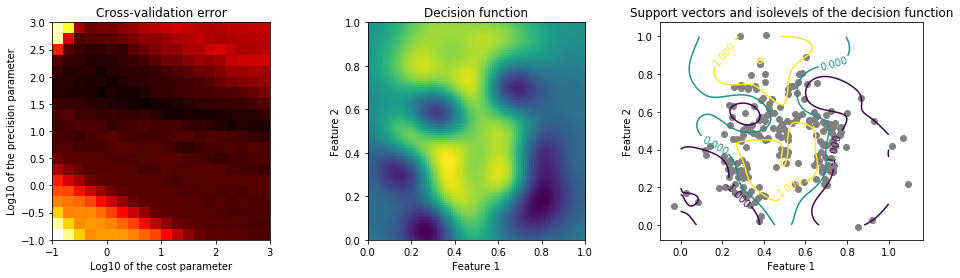

In [7]:
# Sample points on a grid
num_points = 100
x_rng = np.linspace(0, 1, num_points)
y_rng = np.linspace(0, 1, num_points)
grid_x, grid_y = np.meshgrid(x_rng, y_rng)

# Evaluate decision function for each point
xy_list = np.column_stack((grid_x.flat, grid_y.flat))
values = svm.decision_function(xy_list)
values = values.reshape((num_points, num_points))

# Display
fig = plt.figure(figsize=plt.figaspect(0.25))

ax = fig.add_subplot(1, 3, 1)
ax.set_title("Cross-validation error")
ax.set_xlabel("Log10 of the cost parameter")
ax.set_ylabel("Log10 of the precision parameter")
# TODO (Question 1)
ax.imshow(cv_error, extent=[-1, 3, -1, 3], origin='lower', cmap='hot')
# /TODO (Question 1)

ax = fig.add_subplot(1, 3, 2)
ax.set_title("Decision function")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.imshow(values, extent=[0, 1, 0, 1], origin='lower')

ax = fig.add_subplot(1, 3, 3)
ax.set_title("Support vectors and isolevels of the decision function")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
# TODO (Question 2)
#  draw contour lines at the specified levels i.e. at -1/0/1.
contPlt = ax.contour(grid_x, grid_y, values, [-1,0,1])
ax.clabel(contPlt)
# support vectors
ax.scatter(support_vectors[:,0],support_vectors[:,1],c='grey')
# /TODO (Question 2)

plt.show()

## Generalization error

### Load the test data

In [8]:
# Load the training data
test_features = np.load("test_features.npy")
test_labels = np.load("test_labels.npy")
print(test_features.shape)
print(test_labels.shape)

(500, 2)
(500,)


<a id='question3'></a>

### Print the number of misclassified points in the test set

In [9]:
# TODO (Question 3)
predicted_labels = svm.predict(test_features)
num = 0
for i in range(len(predicted_labels)) :
    if test_labels[i] != predicted_labels[i]:
        num += 1

print(num)
# /TODO (Question 3)

90
